# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [27]:
# Imports here
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms, models

from collections import OrderedDict
from PIL import Image
from os import listdir
import json
import time
import copy

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [18]:
# First attempt code left for reference

# TODO: Define your transforms for the training, validation, and testing sets
#train_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                      transforms.RandomResizedCrop(224),
#                                      transforms.RandomHorizontalFlip(),
#                                     transforms.ToTensor(),
#                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
#                                      ])

#valid_transforms = transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
#                                      ])
#
#test_transforms = transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
#                                      ])
#
# TODO: Load the datasets with ImageFolder
#train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
#valid_data = datasets.ImageFolder(valid_dir,transform=valid_transforms)
#test_data = datasets.ImageFolder(test_dir,transform=test_transforms)
#
# TODO: Using the image datasets and the trainforms, define the dataloaders
#train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
#valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=64,shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_data,batch_size=32)


In [3]:
#Define transforms for training and validation sets and normalize images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create dictionary holding location of training and validation data
data_dict = {'train':train_dir,
            'valid': valid_dir}

# Images are loaded with ImageFolder and transformations applied
image_datasets = {x: datasets.ImageFolder(data_dict[x],transform = data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,shuffle=True) 
               for x in ['train', 'valid']}

# Variable used in calculating trining and validation accuracies 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

# Variable holding names for classes
class_names = image_datasets['train'].classes

# Variable to use cuda gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
# Load json file with flower names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
# Quick check of data in json file
df = pd.DataFrame({'flower_type': cat_to_name})
df[:10]

,flower_type
1,pink primrose
10,globe thistle
100,blanket flower
101,trumpet creeper
102,blackberry lily
11,snapdragon
12,colt's foot
13,king protea
14,spear thistle
15,yellow iris


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
# Load pretrained model
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 85208376.54it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
#Freeze feature parameters so as not to backpropagate through them
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Classifier structure from trial and error
classifier = nn.Sequential(OrderedDict([
                           ('fc1',nn.Linear(25088,5120)),
                           ('ReLu1',nn.ReLU()),
                           ('Dropout1',nn.Dropout(p=0.15)),
                           ('fc2',nn.Linear(5120,512)),
                           ('ReLu2',nn.ReLU()),
                           ('Dropout2',nn.Dropout(p=0.15)),
                           ('fc3',nn.Linear(512,102)),
                           ('output',nn.LogSoftmax(dim=1))
                           ]))

model.classifier = classifier

In [9]:
# Criterion chosen has recommended for Log Softmax output.
criterion = nn.NLLLoss()

# Reference for choosing suitable learning rate
# https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

In [10]:
# Scheduler based on PyTorch documentation https://pytorch.org/docs/stable/optim.html
scheduler = lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1,last_epoch=-1)

# Number of steps for gradient descent to take
epochs =10

In [9]:
# First effort to Implement a function for validation left for reference.

#def validation(model,valid_loader,criterion):
#    
#    val_loss = 0
#    accuracy = 0
#    
#    for ii, (inputs, labels) in enumerate(valid_loader):
#        
#        inputs, labels = inputs.to('cuda'), labels.to('cuda')
#        
#        output = model.forward(inputs)
#        val_loss += criterion(output, labels).item()
#        
#        ps = torch.exp(output)
#        equality = (labels.data == ps.max(dim=1)[1])
#        accuracy += equality.type(torch.FloatTensor).mean()
#    
#    return val_loss, accuracy        

In [15]:
#First effort at training the model left for reference

#epochs = 10
#print_every = 80
#steps = 0
#
#model.to('cuda')
#
#from workspace_utils import active_session
#with active_session():
#
#    for e in range(epochs):
#        running_loss = 0
#        model.train()
#        
#        for ii, (inputs, labels) in enumerate(train_loader):
#            steps += 1
#        
#            inputs, labels = inputs.to('cuda'), labels.to('cuda')
#        
#            optimizer.zero_grad()
#        
#            outputs = model.forward(inputs)
#            loss = criterion(outputs, labels)
#            loss.backward()
#            optimizer.step()
#        
#            running_loss += loss.item()
#        
#            if steps % print_every == 0:
#                
#                model.eval()
#                #model.to('cuda')
#                with torch.no_grad():
#                    val_loss, accuracy = validation(model,valid_loader,criterion)
#                
#                print("Epoch: {}/{} .. ".format(e+1,epochs),
#                    "Loss: {:.3f} .. ".format(running_loss/print_every),
#                    "Validation Loss: {:.3f} .. ".format(val_loss/len(valid_loader)),
#                    "Validation Accuracy: %d %%"%(100*(accuracy/len(valid_loader))))
#                
#                running_loss = 0
#                
#                model.train()
#            

In [11]:
# model copied from PyTorch tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model.to('cuda')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_trained = train_model(model, criterion, optimizer, scheduler, epochs)

Epoch 1/10
----------
train loss: 3.0669 Acc: 0.3016
valid loss: 1.2798 Acc: 0.6418

Epoch 2/10
----------
train loss: 1.4971 Acc: 0.5991
valid loss: 0.7623 Acc: 0.7836

Epoch 3/10
----------
train loss: 1.1776 Acc: 0.6778
valid loss: 0.6013 Acc: 0.8289

Epoch 4/10
----------
train loss: 1.0088 Acc: 0.7210
valid loss: 0.5314 Acc: 0.8557

Epoch 5/10
----------
train loss: 0.7556 Acc: 0.7911
valid loss: 0.4006 Acc: 0.8814

Epoch 6/10
----------
train loss: 0.6503 Acc: 0.8172
valid loss: 0.3797 Acc: 0.8924

Epoch 7/10
----------
train loss: 0.6638 Acc: 0.8161
valid loss: 0.3657 Acc: 0.8973

Epoch 8/10
----------
train loss: 0.6401 Acc: 0.8251
valid loss: 0.3419 Acc: 0.8973

Epoch 9/10
----------
train loss: 0.5917 Acc: 0.8332
valid loss: 0.3398 Acc: 0.8985

Epoch 10/10
----------
train loss: 0.6060 Acc: 0.8332
valid loss: 0.3388 Acc: 0.9034

Training complete in 27m 32s
Best valid Acc: 0.9034


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Setting up data for testing
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                      ])

test_data = datasets.ImageFolder(test_dir,transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=32)

In [14]:
# Validation on the test set
correct = 0
total = 0
cum_correct = 0
cum_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model_trained.forward(inputs)
        _, predicted = torch.max(outputs.data,1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        cum_correct = cum_correct + correct
        cum_total = cum_total + total
        
        print('Accuracy of Batch Test Images: {:.1f}%'.format(100*correct/total))

print('Average of Batch Accuracy: {:.1f}%'.format(100*cum_correct/cum_total))
        

Accuracy of Batch Test Images: 81.2%
Accuracy of Batch Test Images: 82.8%
Accuracy of Batch Test Images: 85.4%
Accuracy of Batch Test Images: 88.3%
Accuracy of Batch Test Images: 86.9%
Accuracy of Batch Test Images: 88.5%
Accuracy of Batch Test Images: 85.7%
Accuracy of Batch Test Images: 85.9%
Accuracy of Batch Test Images: 87.2%
Accuracy of Batch Test Images: 88.1%
Accuracy of Batch Test Images: 86.1%
Accuracy of Batch Test Images: 87.2%
Accuracy of Batch Test Images: 88.0%
Accuracy of Batch Test Images: 88.6%
Accuracy of Batch Test Images: 88.3%
Accuracy of Batch Test Images: 88.7%
Accuracy of Batch Test Images: 89.0%
Accuracy of Batch Test Images: 89.6%
Accuracy of Batch Test Images: 90.1%
Accuracy of Batch Test Images: 90.3%
Accuracy of Batch Test Images: 89.9%
Accuracy of Batch Test Images: 89.8%
Accuracy of Batch Test Images: 89.7%
Accuracy of Batch Test Images: 89.8%
Accuracy of Batch Test Images: 89.8%
Accuracy of Batch Test Images: 89.4%
Average of Batch Accuracy: 88.9%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
print(model_trained)
print(model_trained.state_dict().keys())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [18]:
# Save the checkpoint 
model_trained.class_to_idx = image_datasets['train'].class_to_idx
model_trained.cpu()

checkpoint = {              
             'state_dict': model_trained.state_dict(),
             #'optimizer' : optimizer.state_dict(),
             'class_to_idx': model_trained.class_to_idx,
             }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad=False
        
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([
                           ('fc1',nn.Linear(25088,5120)),
                           ('ReLu1',nn.ReLU()),
                           ('Dropout1',nn.Dropout(p=0.15)),
                           ('fc2',nn.Linear(5120,512)),
                           ('ReLu2',nn.ReLU()),
                           ('Dropout2',nn.Dropout(p=0.15)),
                           ('fc3',nn.Linear(512,102)),
                           ('output',nn.LogSoftmax(dim=1))
                           ]))    
    
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [30]:
# Reload the model from saved checkpoint
model = load_checkpoint('checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [31]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    size = 256, 256
    crop_size = 224
    
    im = Image.open(image_path)
    
    if im.width > im.height:
        im.thumbnail((20000,256),Image.ANTIALIAS)
    else:
        im.thumbnail((256,20000),Image.ANTIALIAS)

    left = (size[0] - crop_size)/2
    top = (size[1] - crop_size)/2
    right = (left + crop_size)
    bottom = (top + crop_size)

    im = im.crop((left, top, right, bottom))
    
    np_image = np.array(im)
    np_image = np_image/255
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    np_image = (np_image - means) / stds
    pytorch_np_image = np_image.transpose(2,0,1)
    
    return pytorch_np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [32]:
def imshow(image, ax=None,title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

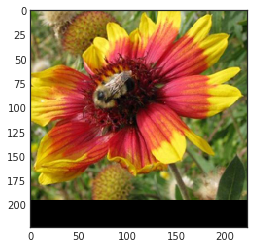

In [45]:
# Test to see if image is correctly shown
sns.set_style("white")
image_path = 'flowers/test/100/image_07896.jpg'
img = process_image(image_path)
imshow(img);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [34]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    pytorch_np_image = process_image(image_path)
    
    # Changing from numpy to pytorch tensor
    pytorch_tensor = torch.tensor(pytorch_np_image)
    pytorch_tensor = pytorch_tensor.float()
    
    # Removing RunTimeError for missing batch size - add batch size of 1 
    pytorch_tensor = pytorch_tensor.unsqueeze(0)
    
    # Run model to make predictions
    model.eval()
    LogSoftmax_predictions = model.forward(pytorch_tensor)
    predictions = torch.exp(LogSoftmax_predictions)
    
    # Identify top predictions and top labels
    top_preds, top_labs = predictions.topk(5)
    
    # Detach top predictions into a numpy list
    top_preds = top_preds.detach().numpy().tolist()
    
    # Change top labels into a list
    top_labs = top_labs.tolist()
    
    # Create a pandas dataframe joining class to flower names
    labels = pd.DataFrame({'class':pd.Series(model.class_to_idx),'flower_name':pd.Series(cat_to_name)})
    labels = labels.set_index('class')
    
    # Limit the dataframe to top labels and add their predictions
    labels = labels.iloc[top_labs[0]]
    labels['predictions'] = top_preds[0]
    
    return labels

In [46]:
predict(image_path,model)

,flower_name,predictions
class,,
2,blanket flower,0.998515
38,barbeton daisy,0.000689
52,sunflower,0.000391
47,english marigold,0.000194
11,purple coneflower,0.000122


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [47]:
# Display an image along with the top 5 classes
def plot_solution(image_path):
    
    labels = predict(image_path,model)
    
    plt.figure(figsize=(5,10))
    ax = plt.subplot(2,1,1)
    
    #flower_num = image_path.split('/')[1]
    #title_ = labels['flower_name'].loc[0]
    
    img = process_image(image_path)
    imshow(img,ax,#title=title_
          );

    sns.set_style("whitegrid")
    plt.subplot(2,1,2)
    sns.barplot(x=labels['predictions'],y=labels['flower_name'],color='#047495')
    plt.xlabel("Probability of Prediction")
    plt.ylabel("")
    plt.show();

sns.set_style("white")

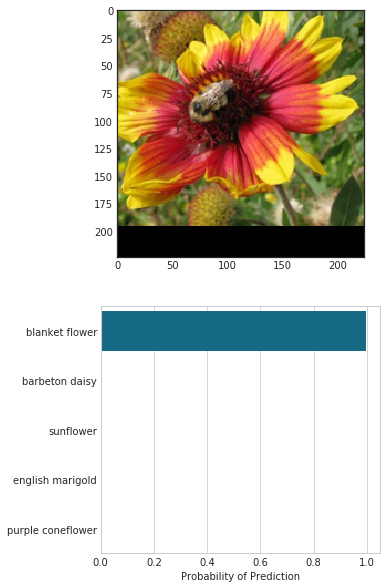

In [48]:
plot_solution(image_path)